# Problem Formulation
Eight decision variables:

h1, h2, h3 -- elevations of Lake Mead where release volumes will change

r1, r2 -- release volumes from Lake Powell to Lake Mead that correspond to each elevation threshold

md1, md2, md3 -- downstream demand of Lake Mead to Lower Basin states based on elevation threshold

First, compile historic data into flowdat = n

Then, write a function that calculates the regulated release between Lake Powell and Lake Mead

Incorporate the regulated release function into a simulation function that simulates the coupled lakes over historic data

Define a class LakeOptimization to set up problem for optimization, then input the problem into NSGAII to optimize

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
!pip install platypus-opt
from platypus.algorithms import NSGAII
from platypus.core import Problem
from platypus.types import Real
import plotly.graph_objects as go

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 2.6 MB/s eta 0:00:00


# Compiling historic data and writing ancillary functions

### In this code block:

- Read in historic inflow, unregulated inflow, and evaporation data for Lake Powell
- Create helper functions for curve fitting
- Create stage-storage curves for Lake Powell and Lake Mead
  - Functions to go elevation <-> storage for both lakes: lakename_elevtostor and lakename_stortoelev
- Create evaporation function for Lake Mead based on evaporation coefficients (inputs are the elevation and the current month)

Data for Lake Powell and Lake Mead are taken from the Data from U.S. Bureau of Reclamation Hydrodata Dashboard:

Lake Powell - https://www.usbr.gov/uc/water/hydrodata/reservoir_data/919/dashboard.html#pool_elevation/

Lake Mead - https://www.usbr.gov/uc/water/hydrodata/reservoir_data/921/dashboard.html#pool_elevation/


In [ ]:
# load in relevant data

# TOTAL INFLOW (inflow and unregulated inflow)
powell_inflow = pd.read_csv('inflow_P.csv')
powell_unreginflow = pd.read_csv('unreginflow_P.csv')

powell_inflow['datetime'] = pd.to_datetime(powell_inflow['datetime'])
powell_unreginflow['datetime'] = pd.to_datetime(powell_unreginflow['datetime'])

powell_totinflow = pd.merge_asof(powell_inflow, powell_unreginflow, on="datetime")
powell_totinflow['unregulated inflow'] = powell_totinflow['unregulated inflow'].fillna(0)
powell_totinflow['total inflow'] = (86400/43560)*(powell_totinflow['inflow'] + powell_totinflow['unregulated inflow'])
# the unit conversion for totinflow is from cfs to acre-ft/day
#print(powell_totinflow)

# EVAPORATION
powell_evap = pd.read_csv('evap_P.csv')
# Convert 'datetime' column in powell_evap to datetime objects
powell_evap['datetime'] = pd.to_datetime(powell_evap['datetime'])
#print(powell_evap)

flowdat = pd.merge(powell_totinflow, powell_evap, on='datetime', how='outer')
flowdat = flowdat.fillna(0)
n = pd.concat(
    [pd.DataFrame([[np.nan] * len(flowdat.columns)], columns=flowdat.columns), flowdat],
    ignore_index=True
)
print(n)

        datetime      inflow  unregulated inflow  total inflow  evaporation
0            NaT         NaN                 NaN           NaN          NaN
1     1963-03-11  4751.42400             0.00000   9424.312066     0.000000
2     1963-03-12  4680.23400             0.00000   9283.108760     0.000000
3     1963-03-13  4645.65600             0.00000   9214.524298     0.000000
4     1963-03-14  4748.37300             0.00000   9418.260496     0.000000
...          ...         ...                 ...           ...          ...
22874 2025-10-24  8761.09666         12075.11150  41328.016185   618.443640
22875 2025-10-25  7691.18742         10184.07860  35455.073098   618.443640
22876 2025-10-26  6591.86206          8909.23003  30745.967782   618.290798
22877 2025-10-27  8407.00760         10135.08850  36777.711273   618.341745
22878 2025-10-28  5975.29687          7267.67831  26267.058208   618.036208

[22879 rows x 5 columns]


/tmp/ipython-input-2316623573.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  n = pd.concat(


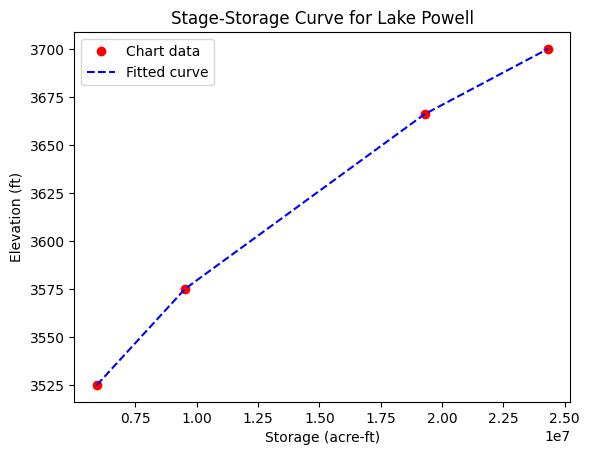

In [ ]:
# get elevation to storage relationship

# Lake Powell
chart_dat = pd.DataFrame(np.array([[3525, 5930000], [3575, 9520000], [3666, 19290000], [3700, 24320000]]),
                         columns = ['elevation', 'storage'])

# forward curve: storage -> elevation
stor_to_elev = PchipInterpolator(chart_dat['storage'], chart_dat['elevation'])

# backward curve: elevation -> storage
elev_to_stor = PchipInterpolator(chart_dat['elevation'], chart_dat['storage'])

def powell_stortoelev(s):
    return stor_to_elev(s)

def powell_elevtostor(h):
    return elev_to_stor(h)

# plot to see the fit
pred = powell_stortoelev(chart_dat['storage'])
fig, ax2 = plt.subplots()
ax2.plot(chart_dat['storage'], chart_dat['elevation'], 'o', color='red', label='Chart data')
ax2.plot(chart_dat['storage'], pred, '--', color='blue', label='Fitted curve')
ax2.set_ylabel('Elevation (ft)')
ax2.set_xlabel('Storage (acre-ft)')
ax2.set_title('Stage-Storage Curve for Lake Powell')
ax2.legend()
plt.show()

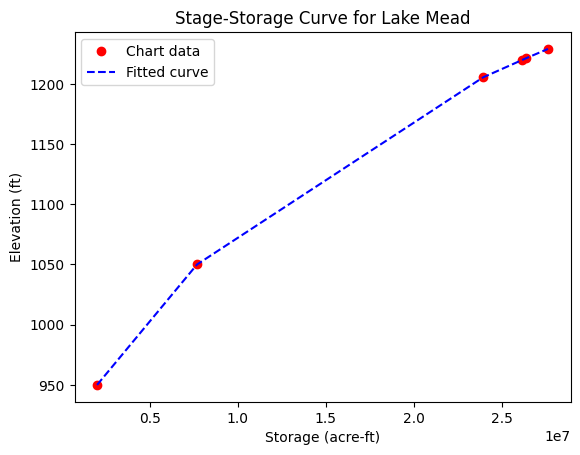

In [ ]:
# need a separate elevation to storage relationship for Lake Mead
chart_dat = pd.DataFrame(np.array([[950, 2006000], [1050, 7683000], [1205.4, 23936000], [1219.6, 26120000],
 [1221.4, 26399000], [1229, 27620000]]),
                         columns = ['elevation', 'storage'])

# forward curve: storage -> elevation
stor_to_elev = PchipInterpolator(chart_dat['storage'], chart_dat['elevation'])

# backward curve: elevation -> storage
elev_to_stor = PchipInterpolator(chart_dat['elevation'], chart_dat['storage'])

def mead_stortoelev(s):
    return stor_to_elev(s)

def mead_elevtostor(h):
    return elev_to_stor(h)

# plot to see the fit
pred = mead_stortoelev(chart_dat['storage'])
fig, ax2 = plt.subplots()
ax2.plot(chart_dat['storage'], chart_dat['elevation'], 'o', color='red', label='Chart data')
ax2.plot(chart_dat['storage'], pred, '--', color='blue', label='Fitted curve')
ax2.set_ylabel('Elevation (ft)')
ax2.set_xlabel('Storage (acre-ft)')
ax2.set_title('Stage-Storage Curve for Lake Mead')
ax2.legend()
plt.show()

In [ ]:
# also need to use stage-storage estimate to estimate evaporation rates for Lake Mead
def mead_evap(elevation, month_i):
  area = mead_elevtostor(elevation) / elevation

  evap_coeff = [0.31, 0.29, 0.32, 0.43, 0.54, 0.67, 0.64, 0.70, 0.68, 0.64, 0.56, 0.46]
  evap_vol = area * evap_coeff[int(month_i)] # in acre-ft
  return evap_vol

# Simulation Functions

### In this code block:
- Write function that calculates the amount of release based on Lake Mead's elevation and other parameters
- Write function that calculates the amount of discharge to the Lower Basin based on Lake Mead's elevation
- Function that runs the simulation of both lakes in conjunction for each timestep

In [ ]:
def regulated_release(param, hm):
  threshold3 = param['h3']

  if (hm >= threshold3):
    r = param['r1']
  else:
    r = param['r2']

  return r

In [ ]:
def regulated_demand(param, hm):
  threshold1 = param['h1']
  threshold2 = param['h2']
  threshold3 = param['h3']

  if (hm >= threshold1):
    dm = 7500000/365
  elif (hm < threshold1 and hm >= threshold2):
    dm = param['md1']
  elif (hm < threshold2 and hm >= threshold3):
    dm = param['md2']
  else:
    dm = param['md3']

  return dm

In [ ]:
def sim_lakes(param, hp_in, hm_in, spmax, n):

  # Integration step and simulation horizon
  H = len(n) - 1              # Simulation horizon [years]
  delta = 1        # Integration step [day/year]

  # Initialize variables for trajectories
  hp = np.full(len(n), np.nan)  # Lake Powell elevation [ft]
  hm = np.full(len(n), np.nan)  # Lake Mead elevation [ft]
  sp = np.full(len(n), np.nan)  # Lake Powell storage [acre-ft]
  sm = np.full(len(n), np.nan)  # Lake Mead storage [acre-ft]
  r = np.full(len(n), np.nan)  # Regulated release from Powell to Mead [acre-ft/day]
  dp = np.full(len(n), np.nan)  # Lake Powell downstream discharge [acre-ft/day]
  dm = np.full(len(n), np.nan)  # Lake Mead downstream discharge [acre-ft/day]
  em = np.full(len(n), np.nan) # Evaporation values for Lake Mead

  # Initial conditions
  hp[0] = hp_in
  hm[0] = hm_in
  sp[0] = powell_elevtostor(hp_in) # Initialize Powell storage from initial elevation
  sm[0] = mead_elevtostor(hm_in)   # Initialize Mead storage from initial elevation
  em[0] = mead_evap(hm_in, 3) # month 3 is March, used for initial evaporation

  # Simulation loop
  for i in range(H):
    # Compute regulated release/demand and other mass balance terms using the provided parameters
    r[i + 1] = regulated_release(param, hm[i])
    dm[i + 1] = regulated_demand(param, hm[i])
    dp[i + 1] = 7500000 / 365
    # Get month for current timestep (i+1), convert to 0-indexed for evap_coeff
    month_i = (n['datetime'].dt.month.iloc[i + 1] - 1)
    em[i + 1] = mead_evap(hm[i], month_i)

    # Update storage based on the mass balance
# ----------------------------------------------------------
    #   Lake Powell mass balance
    # ----------------------------------------------------------
    # Water available after the regulated release r
    powell_available = sp[i] + (n['total inflow'].iloc[i + 1] - r[i+1] - n['evaporation'].iloc[i + 1]) * delta

    if powell_available <= 0:
        # reservoir is empty
        dp[i+1] = 0
        sp[i+1] = 0
    elif powell_available - dp[i+1] > spmax:
        # reservoir is full
        sp[i+1] = spmax
        dp[i+1] = powell_available - spmax
    else:
        # discharge cannot exceed available storage
        dp[i+1] = min(dp[i+1], powell_available)
        sp[i+1] = powell_available - dp[i+1]

    # ----------------------------------------------------------
    #   Lake Mead mass balance
    # ----------------------------------------------------------
    mead_available = sm[i] + (r[i+1] - em[i+1]) * delta           # inflow from Powell
    mead_required = dm[i+1] * delta         # demand + evaporation

    if mead_available <= 0:
        dm[i+1] = 0
        sm[i+1] = 0
    else:
        if mead_available < mead_required:
            # Not enough water to meet demand + evap
            # dm must be reduced
            # available = dm_reduced * delta + em * delta
            dm_reduced = max((mead_available / delta) - em[i+1], 0)
            dm[i+1] = dm_reduced
            sm[i+1] = 0
        else:
            sm[i+1] = mead_available - mead_required

    # Compute new lake level
    hp[i + 1] = powell_stortoelev(sp[i + 1])
    hm[i + 1] = mead_stortoelev(sm[i + 1])

  return sp, sm, hp, hm, r, dp, dm

# Problem Implementation

### In this code block:
- Define class LakeOptimization, which has the problem formulation
- Optimize the problem with NSGAII

In [ ]:
# define lake parameters based on current operational rules
lake_params = {
    'h1': 1075,
    'h2': 1050,
    'h3': 1025,
    'r1': 7480000/365,
    'r2': 8230000/365,
    'md1': (7500000-383000)/365,
    'md2': (7500000-383000-84000)/365,
    'md3': (7500000-383000-84000-83000)/365
}

# write functions that calculate objectives
def alloc_dev(dp, dm):
  target = 7500000/365

  deficit = np.zeros_like(dp, dtype=float)

  cond1 = (dp < target) & (dm >= target)
  deficit[cond1] = np.abs(dp[cond1] - target)

  cond2 = (dp >= target) & (dm < target)
  deficit[cond2] = np.abs(dm[cond2] - target)

  cond3 = (dp < target) & (dm < target)
  deficit[cond3] = np.abs(dp[cond3] - target) + np.abs(dm[cond3] - target)

  return deficit

def hydropower(hp, hm, r, dm):
  eta = 0.9
  return -eta*(hp*r + hm*dm)

In [ ]:
# Define the optimization problem
class LakeOptimization(Problem):
    def __init__(self):
        # Create a problem with 4 decision variables and 2 objectives
        super(LakeOptimization, self).__init__(8, 2)  # 8 decision variables, 2 objectives
        self.types[:] = [Real(1060, 1090), Real(1035, 1060), Real(1010, 1035), Real(20450, 20500), Real(22510, 22590),
                         Real(19400, 195500), Real(19200, 19300), Real(19000, 19080)]

    def evaluate(self, solutions):
        # Check if a single solution is passed
        if not isinstance(solutions, list):
            solutions = [solutions]

        for s in solutions:
            # Simulate the lake with current parameters
            h1, h2, h3, r1, r2, md1, md2, md3 = s.variables
            lake_params['h1'] = h1
            lake_params['h2'] = h2
            lake_params['h3'] = h3
            lake_params['r1'] = r1
            lake_params['r2'] = r2
            lake_params['md1'] = md1
            lake_params['md2'] = md2
            lake_params['md3'] = md3

            # Run the simulation function (ensure this is defined)
            sp, sm, hp, hm, r, dp, dm = sim_lakes(lake_params, 3409, 1036.5, 23280000, n)

            # Compute objectives
            allocation = np.mean(alloc_dev(dp[1:], dm[1:]))
            hydro_gen = -np.mean(hydropower(hp[1:], hm[1:], r[1:], dm[1:]))

            # Set the objectives for the solution
            s.objectives[:] = [allocation, hydro_gen]

In [ ]:
# Create the problem instance
problem = LakeOptimization()

# Set up and run the algorithm
population_size = 50  # Change this to your desired population size
num_generations = 20  # Change this to your desired number of generations
total_evaluations = population_size * num_generations # Calculate total evaluations based on population size and generations
algorithm = NSGAII(problem,population_size=population_size)
algorithm.run(5)

# Extract results for analysis
results = np.array([[s.objectives[0], s.objectives[1]] for s in algorithm.result])
parameters = np.array([s.variables for s in algorithm.result])

# Results
- Inspect results of the genetic algorithm

In [ ]:
print(results)

[[1.55396273e+03 4.08451059e+07]
 [1.49576209e+03 4.02775199e+07]
 [1.48113928e+03 3.99806739e+07]
 [1.46341867e+03 4.00305887e+07]
 [1.46734472e+03 3.99232738e+07]
 [1.51506074e+03 4.05490994e+07]
 [1.50026974e+03 4.02941802e+07]
 [1.58449113e+03 4.07748199e+07]
 [1.58821701e+03 4.08397545e+07]
 [1.56418290e+03 4.08999027e+07]
 [1.52779104e+03 4.06489189e+07]
 [1.54573561e+03 4.05587823e+07]
 [1.48238602e+03 4.00797679e+07]
 [1.57614171e+03 4.07250957e+07]
 [1.48364746e+03 4.03025150e+07]
 [1.56029341e+03 4.05381816e+07]
 [1.44765579e+03 4.00026487e+07]
 [1.47795586e+03 4.03126746e+07]
 [1.43335299e+03 4.00363982e+07]
 [1.49045592e+03 4.02724201e+07]
 [1.53398091e+03 4.03946137e+07]
 [1.56639137e+03 4.05886868e+07]
 [1.51402491e+03 4.02981983e+07]
 [1.56271204e+03 4.07872331e+07]
 [1.52780345e+03 4.06878834e+07]
 [1.47399392e+03 4.01510839e+07]
 [1.53578709e+03 4.07075570e+07]
 [1.48648520e+03 4.01146709e+07]
 [1.53875620e+03 4.07321592e+07]
 [1.43741002e+03 3.99480124e+07]
 [1.517203

In [ ]:
print(parameters)

[[  1070.63218159   1055.47086566   1033.24347701  20499.35155754
   22510.44176221  27846.6080668   19280.89803287  19053.77573274]
 [  1074.86230531   1035.38006574   1019.16040761  20454.09044764
   22556.51259359 106704.69848322  19298.41966953  19021.58413262]
 [  1068.24453347   1054.14065404   1012.68870376  20488.01984069
   22529.01690426  34741.23760135  19258.93134953  19006.80606267]
 [  1087.94855626   1045.69350043   1012.96779916  20478.33862035
   22536.99867302 122435.51066333  19205.43436865  19077.95068932]
 [  1061.49522977   1053.07026426   1010.9555382   20497.38688237
   22570.93155549  73477.01007658  19231.38867514  19032.46311496]
 [  1062.54515487   1036.87974365   1025.68867316  20494.56489096
   22529.53202758 125952.1010458   19281.05937727  19051.92856031]
 [  1080.68778781   1057.39537153   1019.83065261  20462.89742533
   22559.43833907 129750.59018555  19221.15656133  19051.0435257 ]
 [  1084.79818416   1044.59874673   1032.96825878  20478.65426381
   

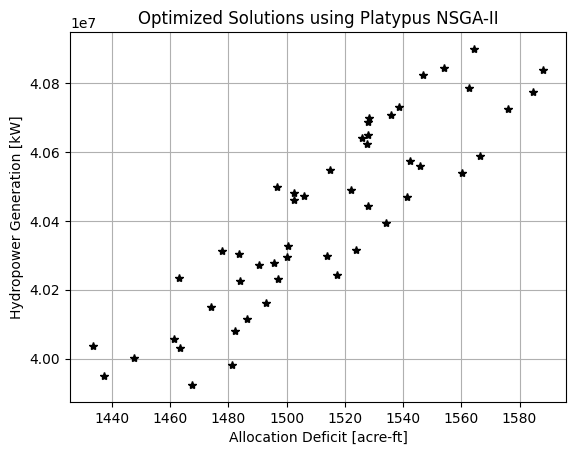

In [ ]:
# Plot results
plt.figure()
plt.plot(results[:, 0], results[:, 1], 'k*')
plt.xlabel('Allocation Deficit [acre-ft]')
plt.ylabel('Hydropower Generation [kW]')
plt.title('Optimized Solutions using Platypus NSGA-II')
plt.grid(True)
plt.show()

# Solution Verification
- Run simulations with a couple select solutions along the Pareto front and ensure they're physically meaningful
- Potentially compare results with historic data

In [ ]:
# Choose point on the front that has lowest deficit:
in_hp = powell_stortoelev(6750000)
in_hm = 1036.5

a = 1500      # threshold for first column
b = 4.04e7     # threshold for second column

# Boolean mask for the condition
mask = (results[:, 0] < a) & (results[:, 1] > b)

# Indices where the condition is met
idx = np.where(mask)[0]

# If you want just the first such index:
#idx = indices[0] if indices.size > 0 else None


#idx = np.argmin(results[1, :])
obj_val = results[idx]
row = parameters[idx][0] # Changed this line to correctly extract the 1D array of parameters
# hard coding the optimal solution so we don't need to run the optimization model every time we test new simulations
#row = [1085.57141887, 1052.24944121, 1030.31301698, 20454.5811912,
#  22537.45483359, 115124.10981341, 19282.99595824, 19040.84546259]
colnames = ["h1", "h2", "h3", "r1", "r2", "md1", "md2", "md3"]
params10 = dict(zip(colnames, row))

sp1, sm1, hp1, hm1, r1, dp1, dm1 = sim_lakes(params10, in_hp, in_hm, 23280000, n)

print(obj_val)
print(row)
# Release for simulated past five years is 20548 acre-ft/day, comparable to the real release value for Mid-Elevation Tier (20493 acre-ft/day)

[[1.49676727e+03 4.04984816e+07]]
[ 1073.76090129  1040.25856662  1023.93112577 20458.05389218
 22531.91249656 71567.7421501  19270.03436517 19070.48100286]


In [ ]:
# Min Deficit Elevation Plot
t = n['datetime'][-365*5:]
hp = hp1[-365*5:]
hm = hm1[-365*5:]
#t = n['datetime']
#hp = hp1
#hm = hm1

fig = go.Figure()

# --- Powell (left y-axis, blue) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=hp,
        mode='lines',
        name='Powell Elevation (ft)',
        line=dict(color='#FFAD9E')
    )
)

# --- Mead (right y-axis, black) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=hm,
        mode='lines',
        name='Mead Elevation (ft)',
        line=dict(color='#4f7fa9'),
        yaxis='y2'
    )
)

# === Layout ===
fig.update_layout(
    title="Min Deficit: Simulated Elevation for Lakes Powell and Mead",
    xaxis=dict(title="Years"),

    yaxis=dict(
        title="Powell Elevation (ft)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
    ),

    yaxis2=dict(
        title="Mead Elevation (ft)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
        overlaying='y',
        side='right'
    ),

    template='plotly_white',
)

fig.show()


In [ ]:
# Min Deficit Storage Plot
t = n['datetime'][-365*5:]
sp = sp1[-365*5:]
sm = sm1[-365*5:]

fig = go.Figure()

# --- Powell (left y-axis, blue) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=sp,
        mode='lines',
        name='Powell Storage (acre-ft)',
        line=dict(color='#FFAD9E')
    )
)

# --- Mead (right y-axis, black) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=sm,
        mode='lines',
        name='Mead Storage (acre-ft)',
        line=dict(color='#4f7fa9'),
        yaxis='y2'
    )
)

# === Layout ===
fig.update_layout(
    title="Min Deficit: Simulated Storage for Lakes Powell and Mead",
    xaxis=dict(title="Years"),

    yaxis=dict(
        title="Powell Storage (acre-ft)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
    ),

    yaxis2=dict(
        title="Mead Storage (acre-ft)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
        overlaying='y',
        side='right'
    ),

    template='plotly_white',
)

fig.show()

In [ ]:
# Min Deficit: Discharge to water supply
t = n['datetime'][-365*5:]
dp = dp1[-365*5:]
dm = dm1[-365*5:]

fig = go.Figure()

# --- Powell (left y-axis, blue) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=dp,
        mode='lines',
        name='Powell Discharge (acre-ft/day)',
        line=dict(color='#FFAD9E')
    )
)

# --- Mead (right y-axis, black) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=dm,
        mode='lines',
        name='Mead Discharge (acre-ft/day)',
        line=dict(color='#4f7fa9'),
        yaxis='y2'
    )
)

# === Layout ===
fig.update_layout(
    title="Min Deficit: Simulated Discharge for Lakes Powell and Mead",
    xaxis=dict(title="Years"),

    yaxis=dict(
        title="Powell Discharge (acre-ft/day)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
    ),

    yaxis2=dict(
        title="Mead Elevation (acre-ft/day)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
        overlaying='y',
        side='right'
    ),

    template='plotly_white',
)

fig.show()

In [ ]:
# Min Deficit: Discharge to water supply
t = n['datetime']
r = r1

fig = go.Figure()

# --- Powell (left y-axis, blue) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=r,
        mode='lines',
        name='Regulated Release (acre-ft/day)',
        line=dict(color='#4f7fa9')
    )
)

# === Layout ===
fig.update_layout(
    title="Min Deficit: Simulated Release from Lake Powell to Lake Mead",
    xaxis=dict(title="Years"),

    yaxis=dict(
        title="Regulated Release (acre-ft/day)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
    ),

    template='plotly_white',
)

fig.show()

In [ ]:
# plot comparison with historic data for Lake Powell
p_historicelev = pd.read_csv('elevation_P.csv')

# Min Deficit: Discharge to water supply
t = n['datetime'][-365*5:]
hp = hp1[-365*5:]
hp_historic = p_historicelev['pool elevation'][-365*5:]

fig = go.Figure()

# --- Powell (left y-axis, blue) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=hp,
        mode='lines',
        name='Simulated Elevation (ft)',
        line=dict(color='#FFAD9E')
    )
)

# --- Mead (right y-axis, black) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=hp_historic,
        mode='lines',
        name='Historic Elevation (ft)',
        line=dict(color='#8E4585'),
        yaxis='y2'
    )
)

# === Layout ===
fig.update_layout(
    title="Simulated vs Actual Elevation for Lake Powell",
    xaxis=dict(title="Years"),

    yaxis=dict(
        title="Simulated Elevation (ft)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
    ),

    yaxis2=dict(
        title="Historic Elevation (ft)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
        overlaying='y',
        side='right'
    ),

    template='plotly_white',
)

fig.show()


In [ ]:
# plot comparison with historic data for Lake Powell
m_historicelev = pd.read_csv('elevation_M.csv')

# Min Deficit: Discharge to water supply
t = n['datetime'][-365*5:]
hm = hm1[-365*5:]
hm_historic = m_historicelev['pool elevation'][-365*5:]

fig = go.Figure()

# --- Powell (left y-axis, blue) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=hm,
        mode='lines',
        name='Simulated Elevation (ft)',
        line=dict(color='#4f7fa9')
    )
)

# --- Mead (right y-axis, black) ---
fig.add_trace(
    go.Scatter(
        x=t,
        y=hm_historic,
        mode='lines',
        name='Historic Elevation (ft)',
        line=dict(color='#8E4585'),
        yaxis='y2'
    )
)

# === Layout ===
fig.update_layout(
    title="Simulated vs Actual Elevation for Lake Mead",
    xaxis=dict(title="Years"),

    yaxis=dict(
        title="Simulated Elevation (ft)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
    ),

    yaxis2=dict(
        title="Historic Elevation (ft)",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
        overlaying='y',
        side='right'
    ),

    template='plotly_white',
)

fig.show()